# Import OSMNX and stuff

### OSRM notes:
```
cd ~/Documents/work/osrm/
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-hampshire-latest.osm.pbf
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-partition /data/new-hampshire-latest.osrm
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-customize /data/new-hampshire-latest.osrm
docker run -t -i -p 5000:5000 -v $(pwd):/data osrm/osrm-backend osrm-routed --algorithm mld /data/new-hampshire-latest.osrm
```

In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib  notebook

In [2]:
# home, origin_point = ox.graph_from_address('42 Wolf Rd, Lebanon, NH 03766, USA', 
#                                            distance=2000, network_type='drive', return_coords=True, )

# The Red Arrow Diner:
home, origin_point = ox.graph_from_address('61 Lowell St, Manchester, NH 03101, USA', 
                                           distance=3000, network_type='drive', return_coords=True, )


## How's it look?

In [3]:
origin_point

(42.9933891, -71.4613916450316)

In [4]:
ox.get_nearest_node(home, origin_point, return_dist=True)

(41352927, 39.267365052682301)

<IPython.core.display.Javascript object>


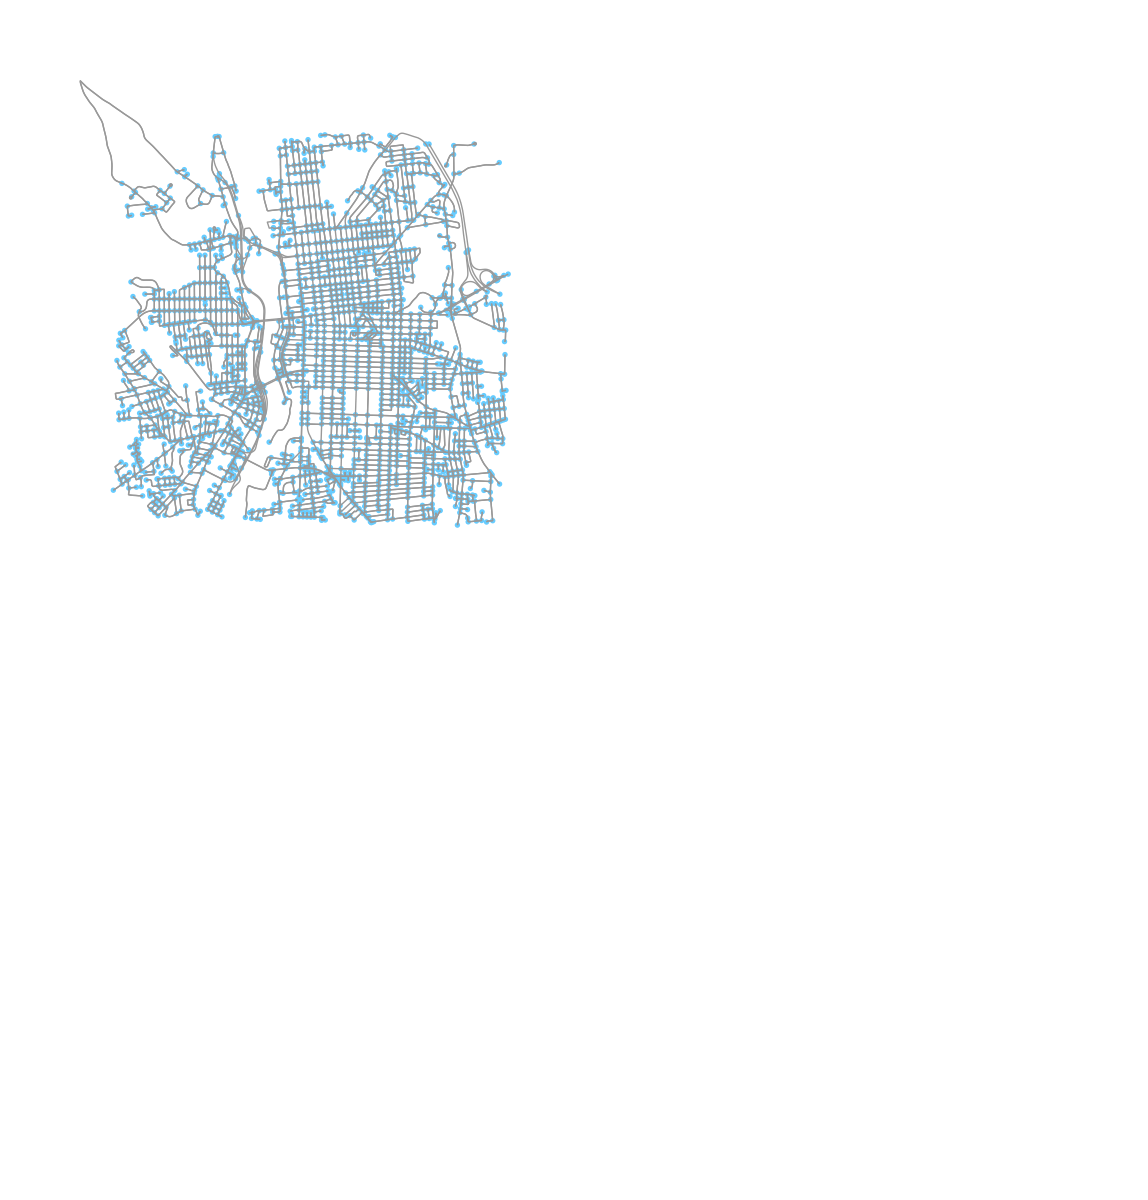

In [5]:
G = home.copy()
# G = nyc.copy()
# G = sf.copy()

center_node = ox.get_nearest_node(G, origin_point)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10)
fig.show()

### COOOOOOL.

### initialize edge traffic to 1, source node traffic to 1:

In [6]:
for u, v, k, data in G.edges(data=True, keys=True):
    data['through_traffic'] = 0
    data['traffic_xy'] = np.array([0.0,0.0]) # to keep track of traffic angles
    
for node, data in G.nodes(data=True):
    data['source_traffic'] = 1
    data['transit_time'] = 0 # np.nan

## This does routing

In [7]:
import requests
import time

In [8]:
# G.node()

In [9]:
def osrm(origin_node, center_node, mode='driving'):
    start = '%f,%f' % (G.node[origin_node]['lon'],G.node[origin_node]['lat'])
    end = '%f,%f' % (G.node[center_node]['lon'],G.node[center_node]['lat'])
    
    for attempt in range(3):
        
        try:
            # router.project-osrm.org
            query = 'http://127.0.0.1:5000/route/v1/%s/%s;%s?steps=true&annotations=true' % (mode,start,end)
            r = requests.get(query)

            route = r.json()['routes'][0]['legs'][0]['annotation']['nodes']
            transit_time = r.json()['routes'][0]['duration']
        except KeyError:
            print('Failed on node %s, retrying...' % origin_node)
            time.sleep(attempt + 1)
            continue
            
    return route,transit_time,r

In [10]:
arr = np.array(G.nodes())
node1 = arr[len(arr)/2]
node1

41570417

In [11]:
route,time,r = osrm(node1, center_node)

In [12]:
center_node

41352927

In [13]:
time

389.6

In [14]:
len(route)

147

In [15]:
r.json()['routes'][0].keys()#['legs']

[u'distance', u'weight', u'weight_name', u'geometry', u'duration', u'legs']

In [16]:
r.json()['routes'][0]['duration']

389.6

In [17]:
r.json().keys()

[u'routes', u'code', u'waypoints']

In [18]:
sum(r.json()['routes'][0]['legs'][0]['annotation']['duration'])

328.7

In [19]:
len(route)

147

In [20]:
len(r.json()['routes'][0]['legs'][0]['annotation']['duration'])

147

In [21]:
# r.json()['routes'][0]['legs']

# Run it on the whole graph!

In [22]:
from tqdm import tqdm
import networkx as nx

In [23]:
# For every node in the map...
missing_edges = set([])
missing_nodes = set([])

for origin_node in tqdm(list(G.nodes())):
    route, transit_time, r = osrm(origin_node, center_node, mode='driving')
    route = [node for node in route if node in list(G)]
    G.node[origin_node]['transit_time'] = transit_time
    
    # for that route, for every edge on the route, increment the through-traffic 
    #  count by the source traffic coming from the origin node..
    for i0, i1 in zip(route[:-1], route[1:]):
        try:
            G.edges[i0,i1,0]['through_traffic'] += G.node[origin_node]['source_traffic'] # new way
            
            # Also, break out the contributions by x/y to help with edge coloring
            n0, n1 = G.nodes[i0],  G.nodes[i1]
            edge = G.edges[i0, i1, 0]

            edge_dy, edge_dx = (n1['y'] - n0['y']), (n1['x'] - n0['x'])
            edge_len = ((edge_dy)**2 + (edge_dx)**2)**.5
            edge['traffic_xy'] += np.array([edge_dx, edge_dy]) / edge_len
        except KeyError:
            missing_edges.update((i0, i1))
            continue

100%|██████████| 2269/2269 [01:16<00:00, 29.58it/s]


# Show it!

In [36]:
import pickle
import numpy as np
import matplotlib.cm as cm
%matplotlib notebook
#notebook

In [37]:
# with open('graphs/tavi-big.pickle', 'rb') as f:
#     G, center_node = pickle.load(f)

In [38]:
G2 = ox.project_graph(G, to_crs=dict(init='epsg:3857'))

In [56]:
# edge_intensity = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_intensity = np.log2(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)])+1)
edge_widths = (edge_intensity / edge_intensity.max() ) * 3 #+ 1
edge_intensity = np.array([G.node[u]['transit_time'] + G.node[v]['transit_time'] for u,v in G.edges()])
edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
edge_intensity = (255 - edge_intensity*255).astype(np.uint8)


# EDGE COLOR: Use the HSL color scheme to change color based on angle of net traffic flow, and
# to change luminance on the basis of edge 'intensity'.
edge_traffic_xy = np.array([data['traffic_xy'] for u, v, data in G.edges(data=True)])
edge_traffic_abs = np.linalg.norm(edge_traffic_xy, axis=1)
edge_angle = np.arctan2(edge_traffic_xy[:,1], edge_traffic_xy[:,0])

import colorsys
h = (edge_angle + np.pi) / 2. / np.pi
s = h*0 + .55
l = np.minimum(1.0, .25 + edge_intensity/255.*.7)
hls = zip(h,l,s)

edge_colors = np.array([colorsys.hls_to_rgb(h, l, s) for h, l, s in hls])
#edge_colors
# cmap = cm.get_cmap(name='magma')
# edge_colors = cmap(edge_intensity)
# node_colors = cmap(node_intensity)

In [57]:
# fig, ax = ox.plot_graph(G2, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, 
#                         save=True, fig_height=8, fig_width=8, dpi=150,# use_geom=True , 
#                         close=False, show=False,  bgcolor='k')

# ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
#            color='red', s=150, zorder=10, alpha=.25)
# ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
#            color='pink', s=100, zorder=10, alpha=.3)
# ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
#            color='yellow', s=50, zorder=10, alpha=.6)
# ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
#            color='white', s=30, zorder=10, alpha=.75)

# # fig.savefig('test.png', facecolor=fig.get_facecolor(), dpi=300)
# # plt.imshow(img, extent=[wm_lon_min, wm_lon_max, wm_lat_min, wm_lat_max])
# # plt.xlim([wm_lon_min, wm_lon_max])
# # plt.ylim([wm_lat_min, wm_lat_max])
# fig.show()


In [58]:
# x0, x1 = ax.get_xlim()
# y0, y1 = ax.get_ylim()
# x0, x1, y0, y1,# tiles.crs

In [59]:
origin_point

(42.9933891, -71.4613916450316)

In [60]:
import mapbox
import io
from pyproj import Proj, transform
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoicmRjaGFtYmVyczIiLCJhIjoiY2plNWFoY2hhN2dmdjJycWh6MHQ4ZTV0dCJ9.3ew5qOrnstnIzRC5fdGZeg'
MOTORSHED_DARK_BG = 'cje59xonc0vkb2rqials45v6s'
MOTORSHED_OVERLAY = 'cje5ad6ul27uh2rsaujjuq8w7'

ss = mapbox.StaticStyle(access_token=MAPBOX_ACCESS_TOKEN)
ZOOM = 13.25
resp = ss.image('rdchambers2', MOTORSHED_DARK_BG, lon=origin_point[1], lat=origin_point[0], zoom=ZOOM, width=1000, height=1000)
resp2 = ss.image('rdchambers2', MOTORSHED_OVERLAY, lon=origin_point[1], lat=origin_point[0], zoom=ZOOM, width=1000, height=1000)

In [61]:

import math

def meters_per_pixel(zoom, lat, pix=256):
    """
    ground resolution = cos(latitude * pi/180) * earth circumference / map width
    """
    return (math.cos(lat * math.pi/180.0) * 2 * math.pi * 6378137) / (pix * 2**zoom)

def map_scale(zoom, lat, dpi=96.0):
    """
    map scale = 1 : ground resolution * screen dpi / 0.0254 meters/inch
    """
    res = meters_per_pixel(zoom, lat)
    return (res * dpi) / 0.0254

def determine_scale(latitude, z):
    """Determine the amount of meters per pixel
    :param latitude: latitude in radians
    :param z: zoom level
    Source: http://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Resolution_and_Scale
    """
    # For zoom = 0 at equator
    meter_per_pixel = 156543.03

    resolution = meter_per_pixel * np.cos(latitude) / (2 ** z)

    return resolution
# print(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), origin_point[1], origin_point[0]))  # longitude first, latitude second.

img = plt.imread(io.BytesIO(resp.content))
img2 = plt.imread(io.BytesIO(resp2.content))
wm_lon, wm_lat = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), origin_point[1], origin_point[0])
# wm_lon_min, wm_lat_min = np.array([wm_lon, wm_lat]) - meters_per_pixel(ZOOM+1, origin_point[0], pix=256) * np.array(img.shape[:2]) / 2.0
# wm_lon_max, wm_lat_max = np.array([wm_lon, wm_lat]) + meters_per_pixel(ZOOM+1, origin_point[0], pix=256) * np.array(img.shape[:2]) / 2.0
scale = determine_scale(origin_point[0], ZOOM)
wm_lon_min, wm_lat_min = np.array([wm_lon, wm_lat]) - scale * np.array(img.shape[:2]) / 2.0
wm_lon_max, wm_lat_max = np.array([wm_lon, wm_lat]) + scale * np.array(img.shape[:2]) / 2.0


wm_lon, wm_lat, wm_lon_min, wm_lat_min, wm_lon_max, wm_lat_max

(-7955045.729303612,
 5310965.6546836365,
 -7959461.484035112,
 5306549.8999521369,
 -7950629.9745721128,
 5315381.4094151361)

In [62]:
len(img)

1000

In [63]:
# # G.node[center_node]

# import cartopy
# from cartopy.io.img_tiles import MapboxTiles
import matplotlib.pyplot as plt

# tiles = MapboxTiles(MAPBOX_ACCESS_TOKEN, MOTORSHED_DARK_BG)

# ax2 = plt.axes(projection=tiles.crs)
# ax2.set_xlim((0,.01))#ax.get_xlim())
# ax2.set_ylim((0, 0.1))#ax.get_ylim())
    
# ax2.add_image(tiles, 12)
# # fig.add_image(tiles)

<IPython.core.display.Javascript object>


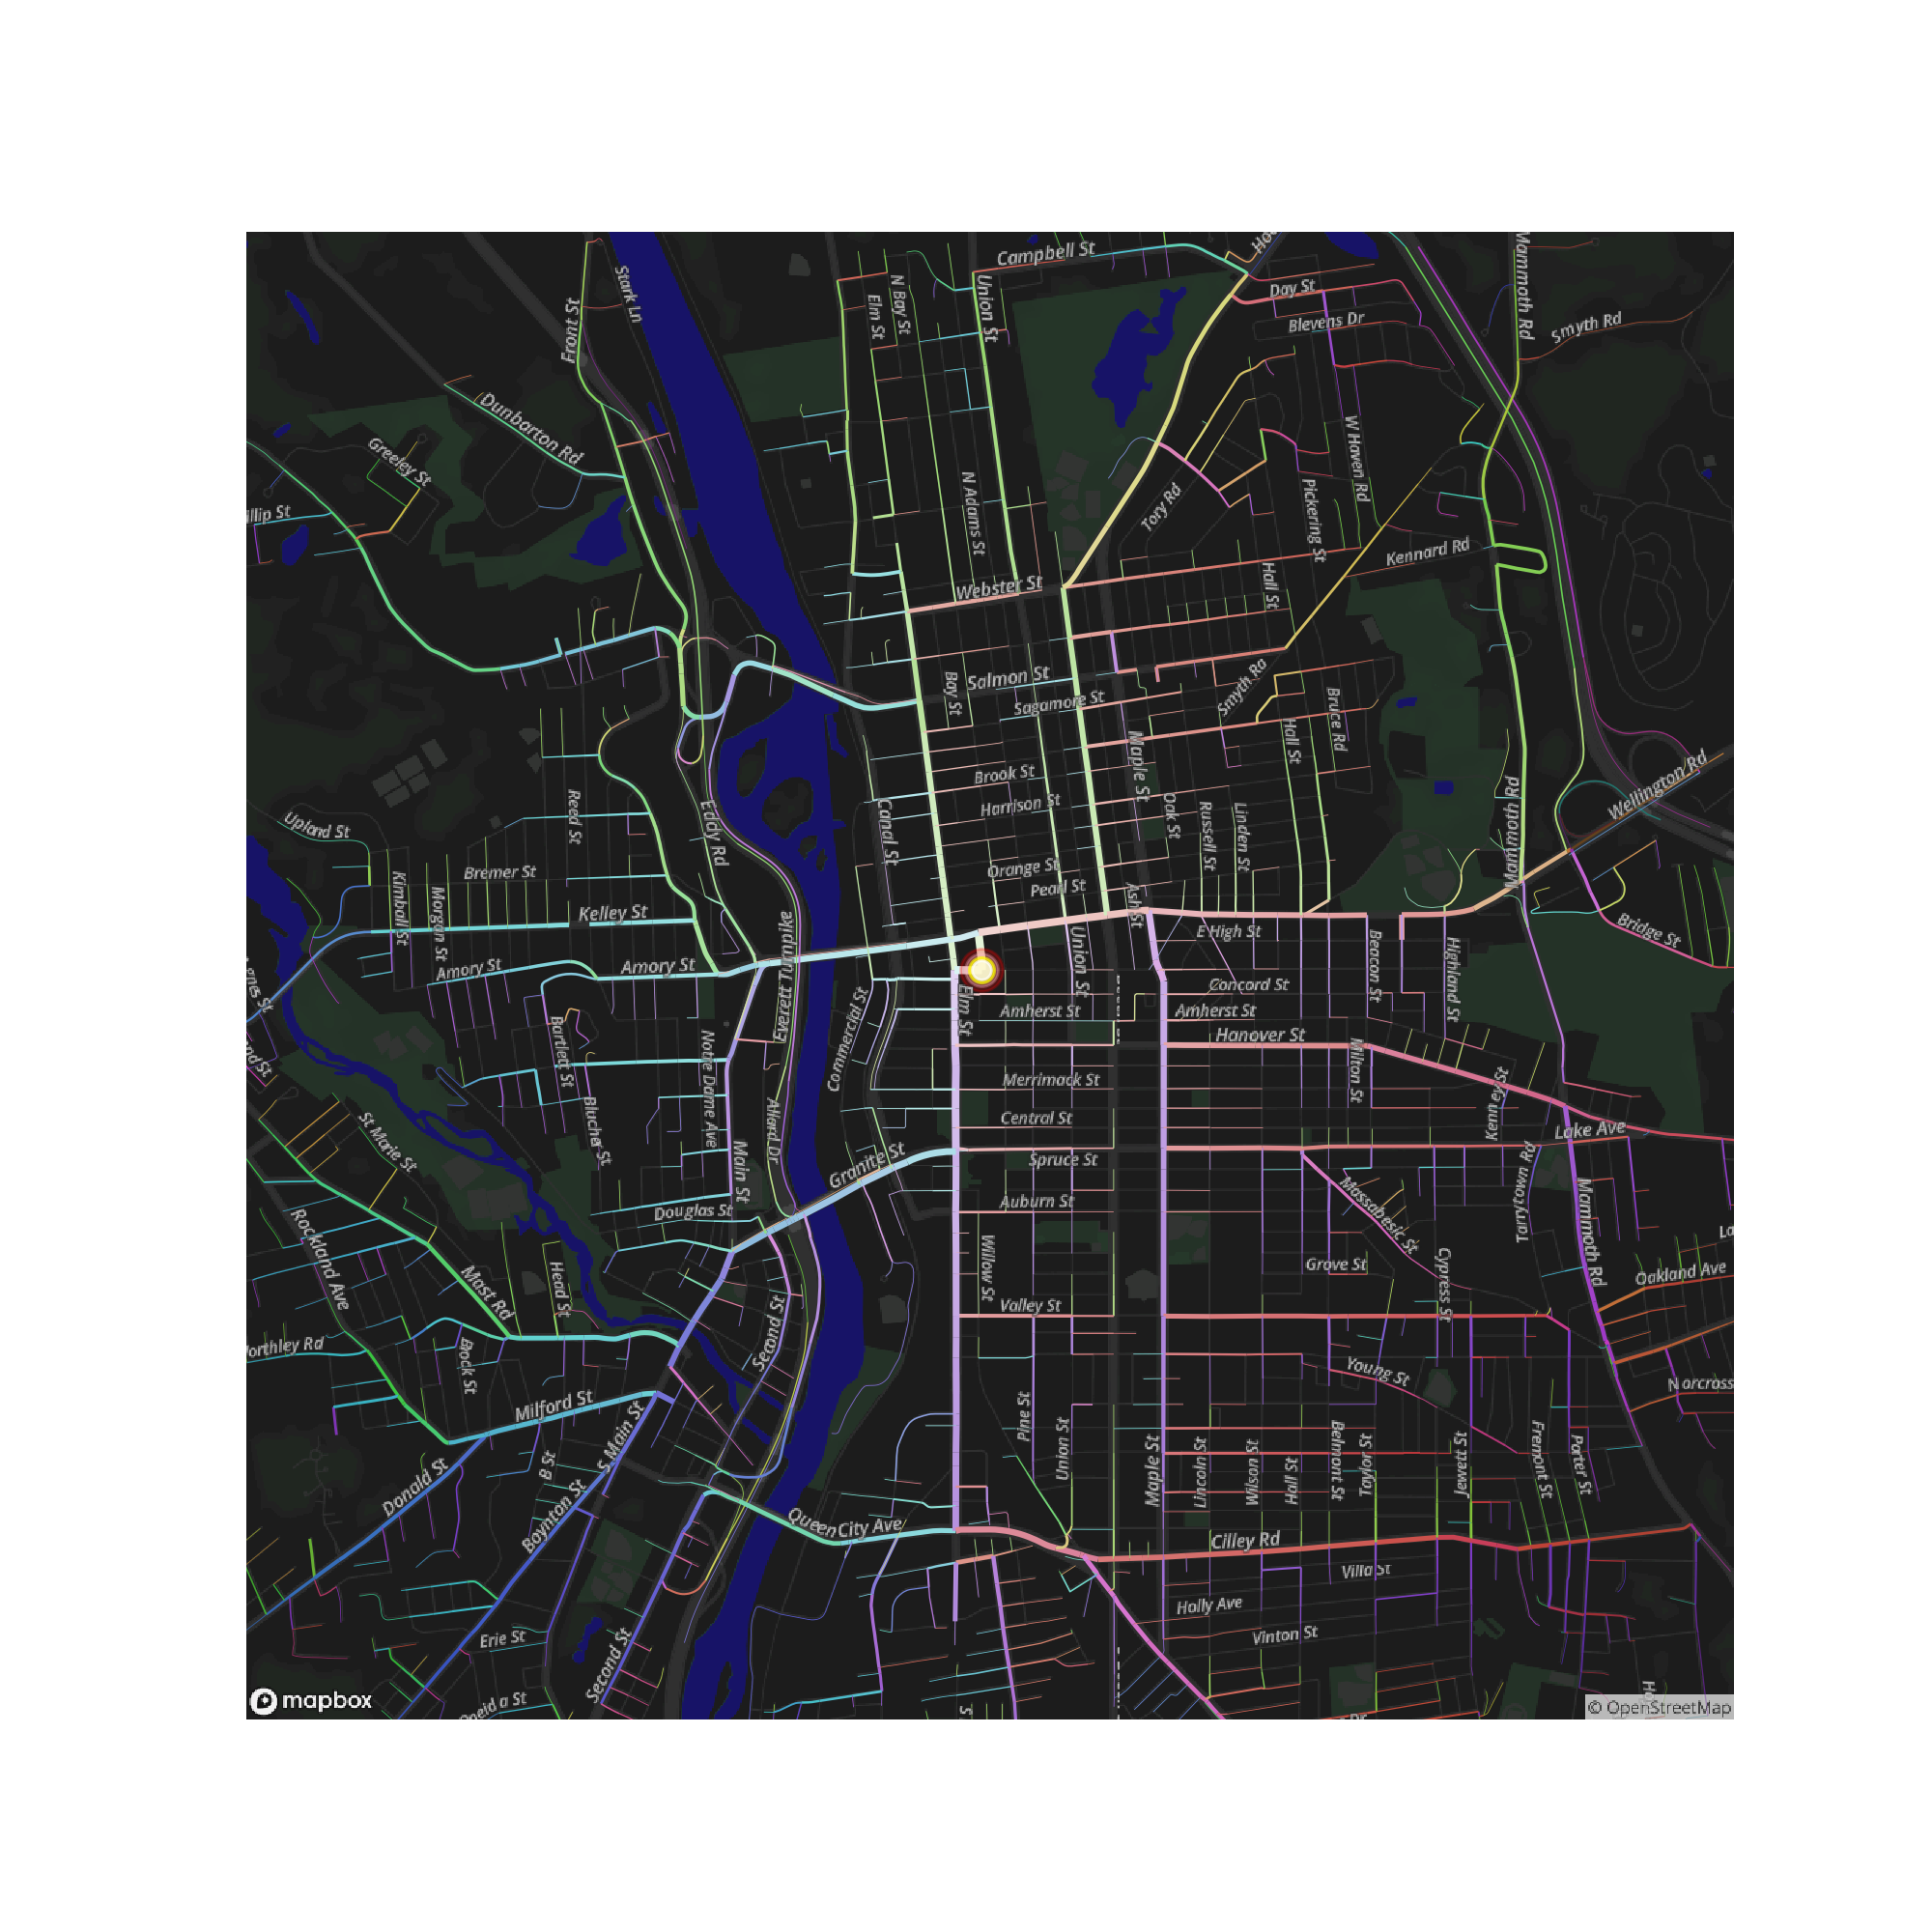

In [64]:
# plt.figure()
scale = determine_scale(origin_point[0], ZOOM+.14)
wm_lon_min, wm_lat_min = np.array([wm_lon, wm_lat]) - scale * np.array(img.shape[:2]) / 2.0
wm_lon_max, wm_lat_max = np.array([wm_lon, wm_lat]) + scale * np.array(img.shape[:2]) / 2.0

fig, ax = ox.plot_graph(G2, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, 
                        save=True, fig_height=10, fig_width=10, dpi=100,# use_geom=True , 
                        close=False, show=False,  bgcolor='k')

ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
           color='red', s=250, zorder=10, alpha=.25)
ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
           color='pink', s=150, zorder=10, alpha=.3)
ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
           color='yellow', s=90, zorder=10, alpha=.6)
ax.scatter([G2.node[center_node]['x']], [G2.node[center_node]['y']],
           color='white', s=50, zorder=10, alpha=.75)

# fig.savefig('test.png', facecolor=fig.get_facecolor(), dpi=300)
plt.imshow(img, extent=[wm_lon_min, wm_lon_max, wm_lat_min, wm_lat_max])
plt.imshow(img2, extent=[wm_lon_min, wm_lon_max, wm_lat_min, wm_lat_max], zorder=1000)
plt.xlim([wm_lon_min, wm_lon_max])
plt.ylim([wm_lat_min, wm_lat_max])
fig.show()
